In [1]:
import os
import numpy as np
from nanowire.optics.simulate import Simulator
from nanowire.optics.postprocess import Simulation
from nanowire.optics.utils.utils import setup_sim
from nanowire.optics.utils.config import Config
import scipy.constants as consts
import scipy.integrate as intg
import IPython.display as disp
import matplotlib.pyplot as plt
%load_ext autoreload 
%autoreload 2

# Polar Angle = 0

This notebook is intended to check the consistency between 3 different methods for calculating the absorption of a layer in S4.
The methods are as follows

1. Using the GetPowerFlux method and taking the difference between what enters the the layer and what leaves the the layer. 
2. Using the GetVolumeIntegral function
3. Integrate the raw field output numerically

All of these methods should agree with one another, so let's verify this. Below I just set up the sim so it's ready for all subsequent computations

In [2]:
conf = Config('GaAs_slab.yml')
sim = Simulator(conf)
sim = setup_sim(sim)
Zo = consts.physical_constants['characteristic impedance of vacuum'][0]

0


## Poynting Flux Method

So at every layer interface, we have both forward and backward modes that each individually carry power. 
The forward direction signifies waves moving downwards, and the backward direction signifies waves moving
upward. A quick note about the indices on the terms. The first index describes the direction (f = forward, b = backward) and the second index describes where we are in the layer (t = top, b = bottom).  Using this
convention, the total power absorbed should be 

\begin{equation}
    P_{abs} = P_{f,t} + P_{b, b} - (P_{b, t} + P_{f, b})
\end{equation}

When S4 returns these numbers, it sticks a minus sign in front of the backward components to signify they are
traveling in the negative z directon (upwards). So, we need to stick an extra minus sign in front of a few
terms as follows:

\begin{equation}
    P_{abs} = P_{f,t} + -1 \cdot P_{b, b} - (-1 \cdot P_{b, t} + P_{f, b})
\end{equation}

And this correctly describes the total amount of power entering minus the total amount of power leaving. I 
implement this calculation below.

In [3]:
fluxes = sim.get_fluxes()

In [4]:
summed_absorbed_power = 0
abs_dict_fluxmethod = {}
for layer, (forw_top, back_top) in fluxes.items():
    if '_bottom' in layer:
        continue
    bottom = layer+'_bottom'
    forw_bot, back_bot = fluxes[bottom] 
    print('-'*25)
    print('Layer: {}'.format(layer))
    print('Forward Top: {}'.format(forw_top))
    print('Backward Top: {}'.format(back_top))
    print('Forward Bottom: {}'.format(forw_bot))
    print('Backward Bottom: {}'.format(back_bot))
    P_in = forw_top + -1*back_bot
    P_out = forw_bot + -1*back_top
    #print('Power Entering Layer: {}'.format(P_in))
    #print('Power Leaving Layer: {}'.format(P_out))
    P_abs = P_in - P_out
    abs_dict_fluxmethod[layer] = .5*P_abs*(sim.period**2)/Zo
    #print('Absorbed in Layer: {}'.format(P_abs))
    summed_absorbed_power += P_abs
#print('Summed Absorption= {}'.format(np.absolute(summed_absorbed_power)))
print('-'*25)
#print('Summed Absorption= {}'.format(summed_absorbed_power))
print('GaAs Absorption = {}'.format(abs_dict_fluxmethod['Substrate']))

-------------------------
Layer: Substrate
Forward Top: (0.8789524823027968+0.005733946606004129j)
Backward Top: (-0.04939949007203206-0.005733946606004129j)
Forward Bottom: (0.3561964186333145+0.00596533760801447j)
Backward Bottom: (-0.11798449944610266-0.00596533760801447j)
-------------------------
Layer: Air
Forward Top: (1+0j)
Backward Top: (-0.1704470077692355+0j)
Forward Bottom: (1+0j)
Backward Bottom: (-0.1704470077692355+0j)
-------------------------
Layer: Below_Air
Forward Top: (0.23821191918721193+0j)
Backward Top: 0j
Forward Bottom: (0.23821191918721193+0j)
Backward Bottom: 0j
-------------------------
GaAs Absorption = (4.905208811790044e-05+0j)


So this just tells us that the incident power is equal to the amplitude of the incident electric field squared.
This is what we would expect, because we know:

\begin{equation}
    S = \frac{1}{c \mu_o} \frac{|E|^2}{2}
\end{equation}

where $S$ is the magnitude of the Poynting vector. In Lorentz-Heaviside units (the units used by S4), $c = \mu_o = 1$, so this also tells us that the power 
values are indeed not time averaged and are missing that factor of .5. This also tells us something about what
the power flux function is giving us back!!!!!! It's either not integrating, or dividing by the area, or something else like that. If it were integrating a uniform poynting vector magnitude 

## GetVolumeIntegral Method

We use the provided S4 function to compute

\begin{equation}
    \int \epsilon | \vec{E} | ^2 dV
\end{equation}
  
(this is what `Quantity = "E"` means in the code below) where the integral is over the volume of the layer. The
total absorbed power is 

\begin{equation}
    P_{abs} = -\frac{\omega}{2} \int Im(\epsilon) | \vec{E} | ^2 dV
\end{equation}

Where here we need to convert $\omega$ into the Lorentz-Heaviside units used by S4. $|E|^2$ should be a purely real quantity,
meaning we can take the imaginary part of the result of the integration and multiply by $\omega / 2$ to get the absorbed 
power.

In [5]:
int_result = sim.s4.GetLayerVolumeIntegral(Layer="Substrate", Quantity="E")
int_result2 = sim.s4.GetLayerVolumeIntegral(Layer="Substrate", Quantity="e")
int_result3 = sim.s4.GetLayerVolumeIntegral(Layer="Substrate", Quantity="U")
epsilon = sim._get_epsilon(os.path.expandvars(
    '$HOME/software/nanowire/nanowire/NK/006_GaAs_nk_Walker_modified_Hz.txt'))
si_freq = sim.conf[('Simulation', 'params', 'frequency', 'value')]
base_unit = sim.conf[('Simulation', 'base_unit')]
c_conv = consts.c / base_unit 
f_conv = si_freq / c_conv
o1 = disp.Latex('$\epsilon = {}$'.format(epsilon))
o2 = disp.Latex("SI $\omega = {}$".format(si_freq))
o3 = disp.Latex("LH $\omega = {}$".format(f_conv))
o4 = disp.Latex('$\int \epsilon |E|^2 dV = {}$'.format(int_result))
o5 = disp.Latex('$\int |E|^2 dV = {}$'.format(int_result2))
o52 = disp.Latex('$\epsilon \int |E|^2 dV = {}$'.format(epsilon*int_result2))
msg = "$P_{abs} = \\frac{\omega}{2} Im(\epsilon) \int |E|^2 dV = " + "{}$".format(.5*f_conv*epsilon.imag*int_result2)
o6 = disp.Latex(msg)
o8 = disp.Latex("$\int \epsilon |E|^2 + |H|^2 dV  = {}$".format(int_result3))
test = disp.display(o1, o2, o3, o4, o5, o52, o6, o8)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

So this is a bit odd. We would expect

\begin{equation}
    \int |E|^2 dV
\end{equation}

to be purely real, but it clearly is not. Don't know what to make of this.

If we do the same thing but using the Lua API and the latest version of S4 on the master branch we get
similiar results. The lua script is below.

In [6]:
%cat volume_integral.lua

S = S4.NewSimulation()
-- Params
period = .25
numbasis = 40
eps_real = 13.77
eps_imag = 0.8
thickness = .5
freq = 1.3342563807926082
--
S:SetVerbosity(9)
S:SetLattice({period,0}, {0,period})
S:SetNumG(numbasis)
S:AddMaterial('Vacuum', {1.0, 0})
S:AddMaterial('GaAs', {eps_real, eps_imag})
S:AddLayer('top', 0, 'Vacuum')
S:AddLayer('slab', thickness, 'GaAs')
S:AddLayerCopy('bottom', 0, 'top')
S:SetExcitationPlanewave(
        {0, 0}, -- phi in [0,180), theta in [0,360)
        {1, 0}, -- s-polarization amplitude and phase in degrees
        {0, 0}) -- p-polarization
S:SetFrequency(freq)
tfr, tbr, tfi, tbi = S:GetPowerFlux('top')
bfr, bbr, bfi, bbi = S:GetPowerFlux('bottom')
print("### Top ###")
print(tfr)
print(tbr)
print(tfi)
print(tbi)
print("### Bottom ###")
print(bfr)
print(bbr)
print(bfi)
print(bbi)
pabs_r = (tfr - bfr) + (tbr - bbr)
pabs_i = (tfi - bfi) + (tbi - bbi)
print("Flux Method Power Absorbed Real: " .. pabs_r)
print("Flux Method Power Absorbed Imag: " .. pabs_i)
int_r, int_

Here is what we get if we run it

In [7]:
output = !! $HOME/software/S4/build/S4 volume_integral.lua

In [8]:
print(output[-7])
print(output[-6])
luaapi_1 = disp.display_latex("$"+output[-2]+"$", raw=True)
luaapi_2 = disp.display_latex("$"+output[-1]+"$", raw=True)
luaapi_3 = disp.display_latex("$"+output[-4]+"$", raw=True)
luaapi_4 = disp.display_latex("$"+output[-3]+"$", raw=True)

Flux Method Power Absorbed Real: 0.59119167316067
Flux Method Power Absorbed Imag: 0


So the results seem to agree decently well between the Lua and Python API. However, regardless of which API
we use, it is troubling that the integral of the electric field intensity has imaginary components.

## Integrate Raw Fields

This approach collects the raw fields from S4 and integrates them over the volume of the layer. Here
we are computing 

\begin{equation}
    \int \epsilon | \vec{E} | ^2 dV
\end{equation}

Which can be broken into real and imaginary parts


\begin{equation}
    \int \epsilon | \vec{E} | ^2 dV = \int Re(\epsilon) | \vec{E} | ^2 dV + i\int Im(\epsilon) | \vec{E} | ^2 dV
\end{equation}

The second term is the one that corresponds to absorbed power, which is given by:

\begin{equation}
    P_{absorbed} = \frac{\omega}{2} \int Im(\epsilon) | \vec{E} | ^2 dV
\end{equation}

In [9]:
def integrate(arr, layer_obj, sim_proc):
    arr_slice = arr[layer_obj.slice]
    zsamps = layer_obj.iend - layer_obj.istart
    z_vals = np.linspace(0, layer_obj.thickness, zsamps)
    x_vals = np.linspace(0, sim_proc.period, sim_proc.x_samples)
    y_vals = np.linspace(0, sim_proc.period, sim_proc.y_samples)
    z_integral = intg.trapz(arr_slice, x=z_vals, axis=0)
    x_integral = intg.trapz(z_integral, x=x_vals, axis=0)
    y_integral = intg.trapz(x_integral, x=y_vals, axis=0)
    return y_integral

In [10]:
def integrate_SI(arr, layer_obj, sim_proc):
    arr_slice = arr[layer_obj.slice]
    zsamps = layer_obj.iend - layer_obj.istart
    z_vals = np.linspace(0, layer_obj.thickness*1e-6, zsamps)
    x_vals = np.linspace(0, sim_proc.period*1e-6, sim_proc.x_samples)
    y_vals = np.linspace(0, sim_proc.period*1e-6, sim_proc.y_samples)
    z_integral = intg.trapz(arr_slice, x=z_vals, axis=0)
    x_integral = intg.trapz(z_integral, x=x_vals, axis=0)
    y_integral = intg.trapz(x_integral, x=y_vals, axis=0)
    return y_integral

In [11]:
sim.get_field()

In [12]:
epsilon = sim._get_epsilon(os.path.expandvars(
    '$HOME/software/nanowire/nanowire/NK/006_GaAs_nk_Walker_modified_Hz.txt'))
print("Epsilon = {}".format(epsilon))
si_freq = sim.conf[('Simulation', 'params', 'frequency', 'value')]
base_unit = sim.conf[('Simulation', 'base_unit')]
c_conv = consts.c / base_unit 
f_conv = si_freq / c_conv
print("SI Freq = {}".format(si_freq))
print("LH Freq = {}".format(f_conv))

Epsilon = (13.767280000000001+0.8017920000000001j)
SI Freq = 400000000000000.0
LH Freq = 1.3342563807926082


We need to multiply by $10^{-6}$ (conversion from micrometers to meters) below because when we perform the integral,
we are doing it in a unit system where the micrometer is our reference length unit. So we have

\begin{align}
    P_{absorbed} &= \frac{\omega}{2} \int Im(\epsilon) | \vec{E} | ^2 dV \\
                 &= \frac{\omega \epsilon_0}{2} \int Im(\epsilon_r) | \vec{E} | ^2 dV
\end{align}

Looking at this dimensionally we have

\begin{equation}
    \frac{rad}{s} \frac{C}{V m} \frac{V^2}{\mu m ^2} \mu m^3
\end{equation}

To end up getting units of Watts (Joules/s), we need to mulitply by a conversion factor from micrometers to
meters. 

Why? This is because Maxwell's equations are scale invariant. We could just have easily asserted that our
reference length unit was a meter if we wanted to. Then, we would not multiply by $10^{-6}$, and the power 
absorbed would be much larger because we would be absorbing over an area on the order of square meters. 

Instead, I have decided that my reference length unit is a micrometer. In that case, we need this extra
factor and the power absorbed becomes much smaller, because we are absorbing light over a much smaller area.

In [13]:
sim_proc = Simulation(simulator=sim)
try:
    Esq = sim_proc.data['normEsquared']
except KeyError:
    Esq = sim_proc.normEsquared()
layer_name = 'Substrate'
layer_obj = sim_proc.layers[layer_name]
si_freq = sim_proc.conf[('Simulation', 'params', 'frequency', 'value')]
base_unit = sim_proc.conf[('Simulation', 'base_unit')]
c_conv = consts.c / base_unit 
f_conv = si_freq / c_conv
n_mat, k_mat = layer_obj.get_nk_matrix(si_freq)
# n and k could be functions of space, so we need to multiply the
# fields by n and k before integrating
res = integrate(Esq, layer_obj, sim_proc)
imag_part = res*(2*n_mat[0, 0]*k_mat[0, 0])
p_abs_imag = .5*2*np.pi*si_freq*consts.epsilon_0*imag_part*1e-6
disp.display_latex("$P_{abs} = \\frac{\omega}{2} Im(\epsilon) \int |E|^2 dV"+" = {}$".format(p_abs_imag), raw=True)
#p_abs_imag = .5*f_conv*imag_part
#disp.display_latex("$P_{abs} = \\frac{\omega}{2} Im(\epsilon) \int |E|^2 dV"+" = {}$".format(p_abs_imag), raw=True)

## Conclusion

### Flux Method

In [14]:
print('Python API:\n')
print('GaAs Absorption = {}'.format(abs_dict_fluxmethod['Substrate']))
print("-"*25)
print("Lua API:\n")
print(output[-7])
print(output[-6])

Python API:

GaAs Absorption = (4.905208811790044e-05+0j)
-------------------------
Lua API:

Flux Method Power Absorbed Real: 0.59119167316067
Flux Method Power Absorbed Imag: 0


### GetVolumeIntegral Method

In [15]:
print('Python API:\n')
test = disp.display(o4, o5, o52, o6, o8)
print("-"*25)
print("Lua API:" )
luaapi_1 = disp.display_latex("$"+output[-2]+"$", raw=True)
luaapi_2 = disp.display_latex("$"+output[-1]+"$", raw=True)
luaapi_3 = disp.display_latex("$"+output[-4]+"$", raw=True)
luaapi_4 = disp.display_latex("$"+output[-3]+"$", raw=True)

Python API:



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

-------------------------
Lua API:


### Integrate Raw Fields

In [16]:
raw_fields3 = disp.Latex("$\int |E|^2 dV = {}$".format(res))
disp.display(raw_fields3)
#disp.display_latex("$Re(\epsilon) \int |E|^2 dV = {}$".format(real_part), raw=True)
disp.display_latex("$Im(\epsilon) \int |E|^2 dV = {}$".format(imag_part), raw=True)
disp.display_latex("$P_{abs} = \\frac{\omega}{2} Im(\epsilon) \int |E|^2 dV"+" = {}$".format(p_abs_imag), raw=True)

<IPython.core.display.Latex object>

In [17]:
pdiff = 100*abs(abs_dict_fluxmethod['Substrate'].real - p_abs_imag)/abs_dict_fluxmethod['Substrate'].real
print("Percent Difference = {}".format(pdiff))

Percent Difference = 0.016783848598341693


# Polar Angle = $\pi/4$

In [18]:
conf = Config('GaAs_slab.yml')
sim = Simulator(conf)
Zo = consts.physical_constants['characteristic impedance of vacuum'][0]
sim.conf['Simulation']['params']['polar_angle']['value'] = np.pi/4
sim = setup_sim(sim)

fluxes = sim.get_fluxes()

summed_absorbed_power = 0
abs_dict_fluxmethod = {}
for layer, (forw_top, back_top) in fluxes.items():
    if '_bottom' in layer:
        continue
    bottom = layer+'_bottom'
    forw_bot, back_bot = fluxes[bottom] 
    print('-'*25)
    print('Layer: {}'.format(layer))
    print('Forward Top: {}'.format(forw_top))
    print('Backward Top: {}'.format(back_top))
    print('Forward Bottom: {}'.format(forw_bot))
    print('Backward Bottom: {}'.format(back_bot))
    P_in = forw_top + -1*back_bot
    P_out = forw_bot + -1*back_top
    #print('Power Entering Layer: {}'.format(P_in))
    #print('Power Leaving Layer: {}'.format(P_out))
    P_abs = P_in - P_out
    abs_dict_fluxmethod[layer] = .5*P_abs*(sim.period**2)/Zo
    #print('Absorbed in Layer: {}'.format(P_abs))
    summed_absorbed_power += P_abs
#print('Summed Absorption= {}'.format(np.absolute(summed_absorbed_power)))
print('-'*25)
#print('Summed Absorption= {}'.format(summed_absorbed_power))
print('GaAs Absorption = {}'.format(abs_dict_fluxmethod['Substrate']))

sim.get_field()

epsilon = sim._get_epsilon(os.path.expandvars(
    '$HOME/software/nanowire/nanowire/NK/006_GaAs_nk_Walker_modified_Hz.txt'))
print("Epsilon = {}".format(epsilon))
si_freq = sim.conf[('Simulation', 'params', 'frequency', 'value')]
base_unit = sim.conf[('Simulation', 'base_unit')]
c_conv = consts.c / base_unit 
f_conv = si_freq / c_conv
print("SI Freq = {}".format(si_freq))
print("LH Freq = {}".format(f_conv))

sim_proc = Simulation(simulator=sim)
try:
    Esq = sim_proc.data['normEsquared']
except KeyError:
    Esq = sim_proc.normEsquared()
layer_name = 'Substrate'
layer_obj = sim_proc.layers[layer_name]
si_freq = sim_proc.conf[('Simulation', 'params', 'frequency', 'value')]
base_unit = sim_proc.conf[('Simulation', 'base_unit')]
c_conv = consts.c / base_unit 
f_conv = si_freq / c_conv
n_mat, k_mat = layer_obj.get_nk_matrix(si_freq)
# n and k could be functions of space, so we need to multiply the
# fields by n and k before integrating
res = integrate(Esq, layer_obj, sim_proc)
imag_part = res*(2*n_mat[0, 0]*k_mat[0, 0])
p_abs_imag = .5*2*np.pi*si_freq*consts.epsilon_0*imag_part*1e-6
disp.display_latex("$P_{abs} = \\frac{\omega}{2} Im(\epsilon) \int |E|^2 dV"+" = {}$".format(p_abs_imag), raw=True)
#p_abs_imag = .5*f_conv*imag_part
#disp.display_latex("$P_{abs} = \\frac{\omega}{2} Im(\epsilon) \int |E|^2 dV"+" = {}$".format(p_abs_imag), raw=True)

0.7853981633974483
-------------------------
Layer: Substrate
Forward Top: (0.878868323791533+0.005732654134601195j)
Backward Top: (-0.04939049340190894-0.005732654134601195j)
Forward Bottom: (0.3561605609148767+0.0059643539342713325j)
Backward Bottom: (-0.11796067485222057-0.0059643539342713325j)
-------------------------
Layer: Air
Forward Top: (0.9999060498015506-6.938893903907228e-18j)
Backward Top: (-0.1704282194119263+6.938893903907228e-18j)
Forward Bottom: (0.9999060498015506-6.938893903907228e-18j)
Backward Bottom: (-0.1704282194119263+6.938893903907228e-18j)
-------------------------
Layer: Below_Air
Forward Top: (0.23819988606265594+0j)
Backward Top: 0j
Forward Bottom: (0.23819988606265594+0j)
Backward Bottom: 0j
-------------------------
GaAs Absorption = (4.9046851553910805e-05+0j)
Epsilon = (13.767280000000001+0.8017920000000001j)
SI Freq = 400000000000000.0
LH Freq = 1.3342563807926082


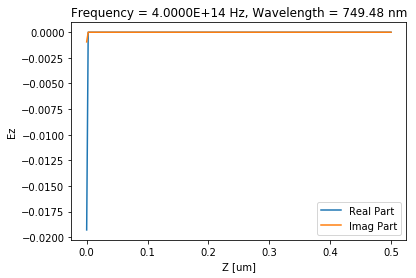

In [19]:
sim_proc.conf['General']['show_plots'] = True
sim_proc.fixed_line('Ez', 'z', 62, 62)

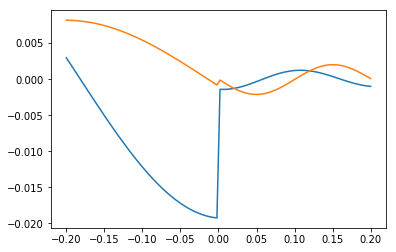

In [20]:
z_vals = np.linspace(-.2, .2, 100)
Ez = np.zeros_like(z_vals, dtype=np.complex)
for i, z in enumerate(z_vals):
    E, H = sim.compute_fields_at_point(0, 0, z)
    Ez[i] = E[2]
plt.figure()
plt.plot(z_vals, Ez.real)
plt.plot(z_vals, Ez.imag)
plt.show()

So agreement is a bit worse with off normal incidence but things still check out